In [56]:
%matplotlib inline
import os, sys
import glob
import time
from datetime import datetime
sys.path.append("../model/")
from tqdm import tqdm

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import keras.backend as K
import keras
import tensorflow as tf

from keras.models import model_from_json
from keras.layers import Lambda
from keras.utils import plot_model, generic_utils
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

from unet import UNET
from vgan import VGAN, DISCRIMINATOR, PIC_DISCRIMINATOR

from train_utils import PlotCheckpoint, send_report_to_slack, set_directory, mean_iou, plot_sample_image
from train_utils import get_disc_batch, np_mean_iou
from train_utils import extract_contour, fill_mask, to_uint8

from data_utils import load_dataset, HumanSegGenerator
from data_utils import clahe_func, gray_func
from data_utils import rotation_func, rescaling_func, flip_func, random_crop_func, random_noise_func, gamma_func
from data_utils import to_tanh, to_sigmoid

from generate_dataset import margin_to_square

from ops import *
import json

### Objective
    
    1. 트레이닝 데이터셋에서 좋지 못한 데이터셋이 섞여 있는지 확인하고자 함.

    현재 가장 우수한 Generator의 모델로 Segmentation을 해보았을 때, human-profile과의 차이가 가장 큰 경우들을 찾아서 배제하고자 함.
    
    2. 크롤링한 데이터 중 아직 누끼를 따지 못한 데이터에 적용해보기
    
    누끼를 따지 못한 데이터에 적용하였을 때 잘 된 것들은 데이터셋에 넣고 잘 되지 못한 것들의 유형을 파악해보기.
    현재 어떤 형태의 데이터를 잘 학습하지 못하는지를 확인하기 위함
   

In [3]:
def get_batch_images(batch_paths, size=(256,256)):
    batch_images = []
    for image_path in batch_paths:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = margin_to_square(image)
        image = cv2.resize(image, size)
        image = to_tanh(image)
        batch_images.append(image)
    return np.stack(batch_images)

def get_batch_profiles(batch_paths):
    batch_images = []
    for image_path in batch_paths:
        image = cv2.imread(image_path,0)
        image = ~image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = margin_to_square(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (256,256))
        image = to_tanh(image)
        batch_images.append(image)
    return np.stack(batch_images)

def np_mean_iou(y_pred, y_true, thr=0):
    y_pred = (y_pred>thr).astype(np.int)
    y_true = (y_true>thr).astype(np.int)

    intersect = y_pred * y_true
    union = np.ones_like(y_pred) - ((1-y_pred) * (1-y_true))
    return np.sum(np.sum(intersect,axis=1),axis=1)\
        / np.sum(np.sum(union,axis=1),axis=1)

def load_model(model_path, weight_path):
    with open(model_path, 'r') as file:
        model = model_from_json(file.read())
    model.load_weights(weight_path)
    return model

def fill_mask(image, profile,line=[1,1,1],fg=[1,0,0]):
    mask = np.expand_dims(profile,axis=-1) * np.array(line,dtype=np.uint8)
    contour = extract_contour(profile)
    contour = np.expand_dims(contour,axis=-1) * np.array(fg,dtype=np.uint8)
    result = cv2.addWeighted(image,0.5,mask,0.5,1.)
    return cv2.add(result,contour)

In [4]:
gen_model_path = "../results/gan/0701_05/model-arch/generator.json"
gen_weight_path = "../results/gan/0701_05/weights/0.909_gen.h5"

disc_model_path = "../results/gan/0701_05/model-arch/discriminator.json"
disc_weight_path = "../results/gan/0701_05/weights/0.909_disc.h5"

csv_path = "../data/remove_bad_seg_df.csv"

In [5]:
df = pd.read_csv(csv_path)
df['IOU'] = 0.
df['human_disc_output'] = 0.
df['machine_disc_output'] = 0.

target_df = df[df.seg_ok]

In [7]:
generator = load_model(gen_model_path, gen_weight_path)
discriminator = load_model(disc_model_path, disc_weight_path)

#### 생성 모델의 성능 평가 - IOU

    IOU는 Human Seg와 Machine Seg의 직접적인 결과차이
    
    discriminator는 기계와 인간의 차이를 구분하는 분류기로
    discriminator의 값이 크면 클수록 기계에 가깝게 되었다고 판별함
    
    

In [21]:
for i in tqdm(range(target_df.shape[0]//4+1)):
    filenames = target_df.filename[4*i:4*(i+1)].values

    batch_image_paths = [os.path.join("../../data/images/",filename) for filename in filenames]
    batch_profile_paths = [os.path.join("../../data/profiles/",filename) for filename in filenames]

    images = get_batch_images(batch_image_paths)
    profiles = get_batch_profiles(batch_profile_paths)
    gen_profiles = generator.predict_on_batch(images)
    
    target_df['IOU'].iloc[4*i:4*(i+1)] = np_mean_iou(np.squeeze(gen_profiles),profiles)
    
    disc_input = np.concatenate([images, np.expand_dims(profiles,axis=-1)],axis=-1)
    disc_input2 = np.concatenate([images, gen_profiles],axis=-1)
    
    target_df['human_disc_output'].iloc[4*i:4*(i+1)] = discriminator.predict_on_batch(disc_input)[:,0]
    target_df['machine_disc_output'].iloc[4*i:4*(i+1)] = discriminator.predict_on_batch(disc_input2)[:,0]


  0%|          | 0/477 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [ ]:
for filename in target_df[target_df.IOU < 0.95].filename

### 이것을 보면 알겠지만, 판별기는 잘 구별하지 못하고 있다. (매우 잘 학습되었다고 볼 수 있음)

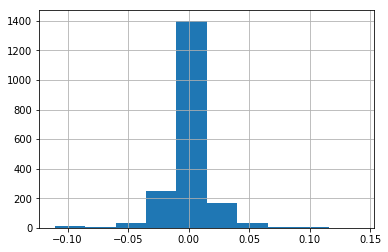

In [31]:
(target_df.machine_disc_output - target_df.human_disc_output).hist()

### 잘 구별 못하지만, IOU가 매우 다른 것들이 존재한다. 왜 그러는지를 분석해 볼 필요가 있다.

In [38]:
eval_dir = "../results/gan/0701_05/evaluation"

os.makedirs(eval_dir,exist_ok=True)
target_df.to_csv(os.path.join(eval_dir,"baidu_evaluation.csv"))

In [39]:
def draw_sample_image(images, profiles):
    images = np.stack([to_uint8(image) for image in np.squeeze(images)])
    profiles = np.stack([to_uint8(image) for image in np.squeeze(profiles)])
    samples = []
    for image, profile in zip(images, profiles):
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        result = fill_mask(image, profile)
        samples.append(np.concatenate((image,result),axis=1))
    samples = np.concatenate(samples,axis=0)
    return samples

In [46]:
save_df = target_df[target_df.IOU < 0.95]

In [48]:
for i in tqdm(range(save_df.shape[0]//4+1)):
    filenames = save_df.filename[4*i:4*(i+1)].values

    batch_image_paths = get_image_paths(filenames)
    batch_profile_paths = get_batch_paths(filenames)

    images = get_batch_images(batch_image_paths)
    profiles = get_batch_profiles(batch_profile_paths)
    gen_profiles = generator.predict_on_batch(images)
    
    for j in range(len(filenames)):
        save_path = os.path.join(eval_dir, filenames[j])
        image = to_uint8(images[j])
        human_contour = to_uint8(fill_mask(images[j],profiles[j],[1,0,0],[1,0,0]))
        machine_contour = to_uint8(fill_mask(images[j],np.squeeze(gen_profiles[j]),[0,1,0],[0,1,0]))
        merged = cv2.addWeighted(human_contour,0.5,machine_contour,0.5,1.3)
        result = np.concatenate([image,human_contour,machine_contour,merged],axis=1)
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path,result)

100%|█████████▉| 250/251 [01:58<00:00,  2.11it/s]

ValueError: need at least one array to stack

In [ ]:
eval_dir = "../../data/evaluation/all/"
os.makedirs(eval_dir, exist_ok=True)

In [ ]:
for i in tqdm(range(df.shape[0]//4+1)):
    filenames = df.filename[4*i:4*(i+1)].values

    batch_image_paths = get_image_paths(filenames)
    batch_profile_paths = get_batch_paths(filenames)

    images = get_batch_images(batch_image_paths)
    profiles = get_batch_profiles(batch_profile_paths)
    gen_profiles = generator.predict_on_batch(images)
    
    for j in range(len(filenames)):
        save_path = os.path.join(eval_dir, filenames[j])
        image = to_uint8(images[j])
        human_contour = to_uint8(fill_mask(images[j],profiles[j],[1,0,0],[1,0,0]))
        machine_contour = to_uint8(fill_mask(images[j],np.squeeze(gen_profiles[j]),[0,1,0],[0,1,0]))
        merged = cv2.addWeighted(human_contour,0.5,machine_contour,0.5,1.3)
        result = np.concatenate([image,human_contour,machine_contour,merged],axis=1)
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path,result)

In [49]:
df = pd.read_csv("../results/gan/0701_05/model-arch/training.csv")

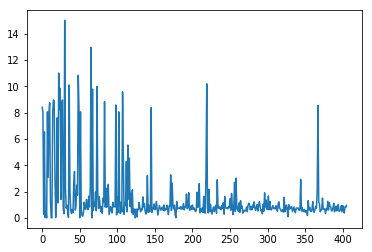

In [53]:
df['train D logloss'].plot()

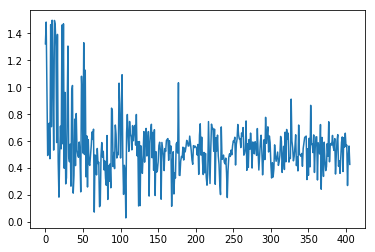

In [52]:
df['train G logloss'].plot()